<a href="https://colab.research.google.com/github/zp20945/DSDM/blob/main/assignment/CE888_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from os.path import join
# Load path of training dataset
image_dir = 'D:/ce888/Training/'

##   give local system path where training data is stored.  ###

In [ ]:
import pathlib
# Import images 
data_dir = pathlib.Path(image_dir)

In [ ]:
# list total number of images in training dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

39375


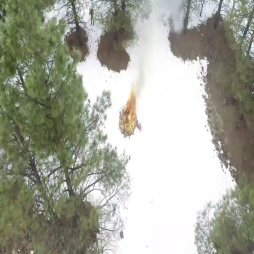

In [ ]:
# display sample of fire image
Fire = list(data_dir.glob('Fire/*'))
PIL.Image.open(str(Fire[2]))

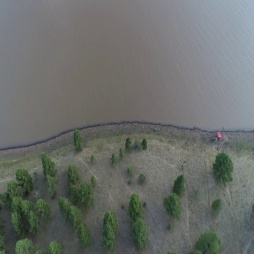

In [ ]:
# display sample of no-fire image
NoFire = list(data_dir.glob('No_Fire/*'))
PIL.Image.open(str(NoFire[1]))

In [ ]:
#initialize variables
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# load train images with preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,         #split data into train set and validation set
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39375 files belonging to 2 classes.
Using 31500 files for training.


In [ ]:
# load validation data with preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


In [ ]:
# print class names of data
class_names = train_ds.class_names
print(class_names)

['Fire', 'No_Fire']


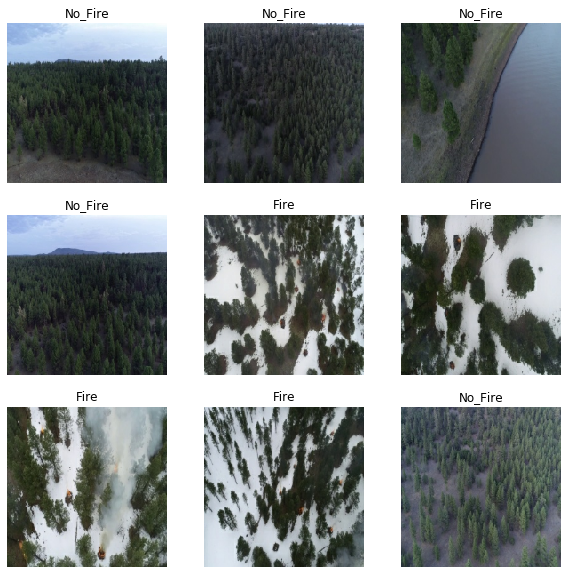

In [ ]:
# plot fire and no-fire image samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# print the shape of images
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
# rescal the images
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
# image preprocessing
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.060180843 1.0


In [ ]:
# create the model
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
# train model for 3 epochs
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
985/985 [==============================] - 3434s 3s/step - loss: 0.1414 - accuracy: 0.9473 - val_loss: 0.0245 - val_accuracy: 0.9915
Epoch 2/3
985/985 [==============================] - 3861s 4s/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0097 - val_accuracy: 0.9971
Epoch 3/3
985/985 [==============================] - 3079s 3s/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0147 - val_accuracy: 0.9953


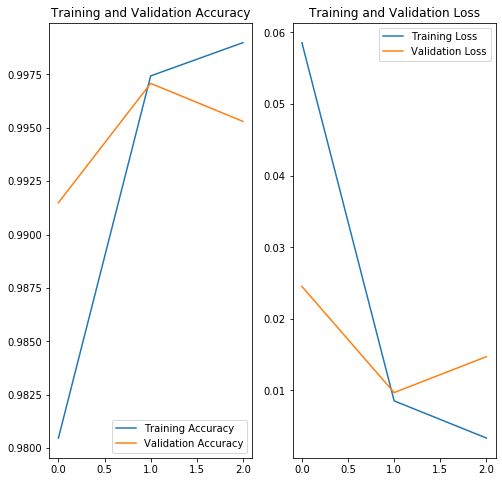

In [ ]:
# plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# predict one of the test image
img = keras.preprocessing.image.load_img("D:/ce888/Test/Fire/resized_test_fire_frame14.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to No_Fire with a 99.84 percent confidence.


In [ ]:
# data augmentation process
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

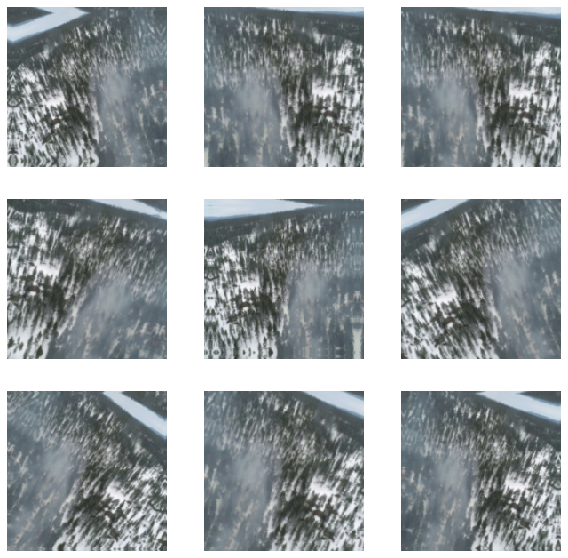

In [ ]:
# data augmentation images sample
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# model creation
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# summary of model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
# train model for 5 epochs
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
985/985 [==============================] - 3893s 4s/step - loss: 0.2383 - accuracy: 0.9223 - val_loss: 0.0834 - val_accuracy: 0.9718
Epoch 2/5
985/985 [==============================] - 3983s 4s/step - loss: 0.0827 - accuracy: 0.9706 - val_loss: 0.0453 - val_accuracy: 0.9843
Epoch 3/5
985/985 [==============================] - 3826s 4s/step - loss: 0.0521 - accuracy: 0.9825 - val_loss: 0.0451 - val_accuracy: 0.9837
Epoch 4/5
985/985 [==============================] - 3808s 4s/step - loss: 0.0386 - accuracy: 0.9871 - val_loss: 0.0193 - val_accuracy: 0.9934
Epoch 5/5
985/985 [==============================] - 3837s 4s/step - loss: 0.0304 - accuracy: 0.9890 - val_loss: 0.0180 - val_accuracy: 0.9934


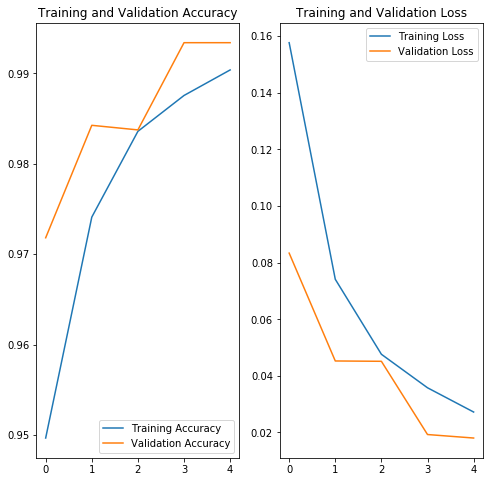

In [ ]:
# plot train and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#predict one of the test image
img = keras.preprocessing.image.load_img("D:/ce888/Test/No_Fire/resized_test_nofire_frame6.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(np.max(score))


0.83790886


In [ ]:
# Store test dataset path
image_dir2 = 'D:/ce888/Test/'

##   give local system path where training data is stored.  ###

In [ ]:
# load validation data with preprocessing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_dir2,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8617 files belonging to 2 classes.


In [ ]:
# give path where you want to save the model
checkpoint_path = "D:\ce888\cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Make a callback and save the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with callback 
model.fit(train_ds,   
          epochs=1,
          validation_data=(val_ds),
          callbacks=[cp_callback])  # Pass callback to training



985/985 [==============================] - 3921s 4s/step - loss: 0.0204 - accuracy: 0.9932 - val_loss: 0.0195 - val_accuracy: 0.9945

Epoch 00001: saving model to D:\ce888\cp.ckpt


In [ ]:
# list of directories
os.listdir(checkpoint_dir)

['.ipynb_checkpoints',
 '2012.14036.pdf',
 'checkpoint',
 'cp.ckpt.data-00000-of-00001',
 'cp.ckpt.index',
 'data',
 'Images',
 'Masks',
 'Masks.zip',
 'New folder',
 'Project_1.pdf',
 'pytorch.ipynb',
 'Test',
 'Testing',
 'Training',
 'Untitled.ipynb',
 'Untitled1.ipynb']

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

270/270 - 710s - loss: 1.9505 - accuracy: 0.6399
Restored model, accuracy: 63.99%


In [ ]:
# save model
file_model_fire = 'D:/ce888/'      # give path where you want to save model
model.save(file_model_fire)        # save the model

INFO:tensorflow:Assets written to: D:/ce888/assets


In [ ]:
# Load model
from tensorflow.keras.models import load_model
model_fire = load_model('D:/ce888/')

In [ ]:
# Evaluate test dataset
results_eval = model_fire.evaluate(test_ds, batch_size=batch_size)

270/270 [==============================] - 526s 2s/step - loss: 1.9505 - accuracy: 0.6399


In [ ]:
# print loss and accuracy
for name, value in zip(model_fire.metrics_names, results_eval):
  print(name, ': ', value)
print()

loss :  1.9504830837249756
accuracy :  0.639897882938385



In [ ]:
# load test data of fire images
test_fire_ds = tf.keras.preprocessing.image_dataset_from_directory( "D:/ce888/Testing/Fire_set", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

# load test data of no-fire images
test_no_fire_ds = tf.keras.preprocessing.image_dataset_from_directory( "D:/ce888/Testing/No_Fire_set", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

# evaluate the model for test fire images
fire_eval = model_fire.evaluate(test_fire_ds)
# evaluate the model for test no-fire images
no_fire_eval = model_fire.evaluate(test_no_fire_ds)

# store length of fire test data
true_fire = len(tf.io.gfile.listdir("D:/ce888/Testing/Fire_set"))
# store length of no-fire test data
true_no_fire = len(tf.io.gfile.listdir("D:/ce888/Testing/No_Fire_set"))

tp = fire_eval[1] * true_fire          # true positive
fp = (1 - fire_eval[1]) * true_fire     # false positive
tn = (1 - no_fire_eval[1]) * true_no_fire   # true negative
fn = no_fire_eval[1] * true_no_fire         # false negative
cm = np.array([[tp, fn], [fp, tn]], dtype=int)    # confusion metrics
print(cm)

Found 5137 files belonging to 1 classes.
Found 3480 files belonging to 1 classes.
 70/109 [==================>...........] - ETA: 1:18 - loss: 2.0705 - accuracy: 0.6308